**Importing Necessary Libraries**

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

#Setting display options for better visualization
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*50)
print("TELECOM CUSTOMER CHURN PREDICTION")
print("="*50)
print("Created by:[Ayush Singh]")
print("="*50)


TELECOM CUSTOMER CHURN PREDICTION
Created by:[Ayush Singh]


**Data Loading & Initial Exploration**

In [91]:
#Loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/ayushbora2003/Telecom_Customer_Churn_Prediction/main/data/Data_file.csv')



In [92]:
#Basic Information
print(f"\nDataset Shape:{df.shape}")
print(f"Total Records:{df.shape[0]}")
print(f"Total Features:{df.shape[1]}")

#Displaying first few rows
df.head()
#Checking data types
df.dtypes


Dataset Shape:(7043, 21)
Total Records:7043
Total Features:21


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


**Data Cleaning and Preprocessing**

In [93]:
#Checking for missing values
missing_values=df.isnull().sum()
print(missing_values[missing_values>0])

TotalCharges    11
dtype: int64


In [94]:
#Handling missing values in TotalCharges
if'TotalCharges' in df.columns:
  #converting TotalCharges to numeric, coerce errors to NaN
  df['TotalCharges']=pd.to_numeric(df['TotalCharges'], errors='coerce')

  # Checking how many missing values
  missing_total=df['TotalCharges'].isnull().sum()
  print(f"\n Missing values in TotalCharges:{missing_total}")

  #Filling missing values with 0(assuming new customers)
  df['TotalCharges'].fillna(0,inplace=True)
  print("Missing values in TotalCharges filled with 0")

  # Also checking for empty strings that might represent missing values
  # Converting any empty strings or whitespace to NaN for other columns
  df=df.replace(r'^\s*$',np.nan, regex=True)

  #Filling other categorical missing values with 'unknown'
  categorical_cols=df.select_dtypes(include=['object']).columns
  for col in categorical_cols:
    if df[col].isnull().any():
      df[col].fillna('unknown',inplace=True)
      print(f"Missing values in {col}filled with'unknown'")

  #Removing customerID as it's not useful for prediction
  if 'customerID' in df.columns:
    df=df.drop('customerID',axis=1)
    print("Removed customerID column (unique identifier)")

  #Cheking the cleaned dataset
  print(f"\n Dataset after cleaning:")
  print(f"shape{df.shape}")
  print(f"Remaining missing values:{df.isnull().sum()}")



 Missing values in TotalCharges:11
Missing values in TotalCharges filled with 0
Removed customerID column (unique identifier)

 Dataset after cleaning:
shape(7043, 20)
Remaining missing values:gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


**Exploratory Data Analysis(EDA)**


Target Variable Analysis(churn)


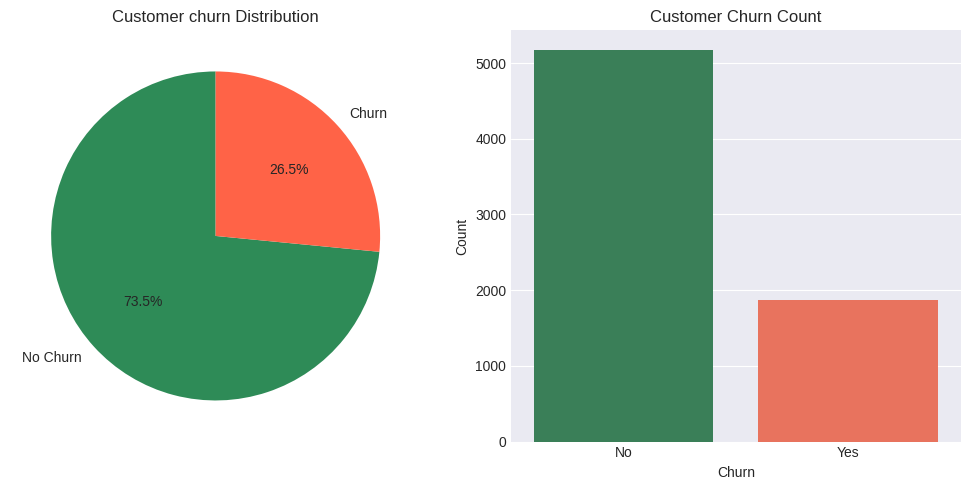


 Churn Rate:26.54%
 Non-Churn Rate:73.46%


In [95]:
#Target variable analysis
print("\nTarget Variable Analysis(churn)")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
churn_counts=df['Churn'].value_counts()
colors=['#2E8B57','#FF6347']
plt.pie(churn_counts.values, labels=['No Churn','Churn'],autopct='%1.1f%%', colors=colors,startangle=90)
plt.title('Customer churn Distribution')

plt.subplot(1,2,2)
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=colors)
plt.title('Customer Churn Count')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


churn_rate=df['Churn'].value_counts(normalize=True)['Yes']*100
print(f"\n Churn Rate:{churn_rate:.2f}%")
print(f" Non-Churn Rate:{100-churn_rate:.2f}%")


Numerical columns:['tenure', 'MonthlyCharges', 'TotalCharges']


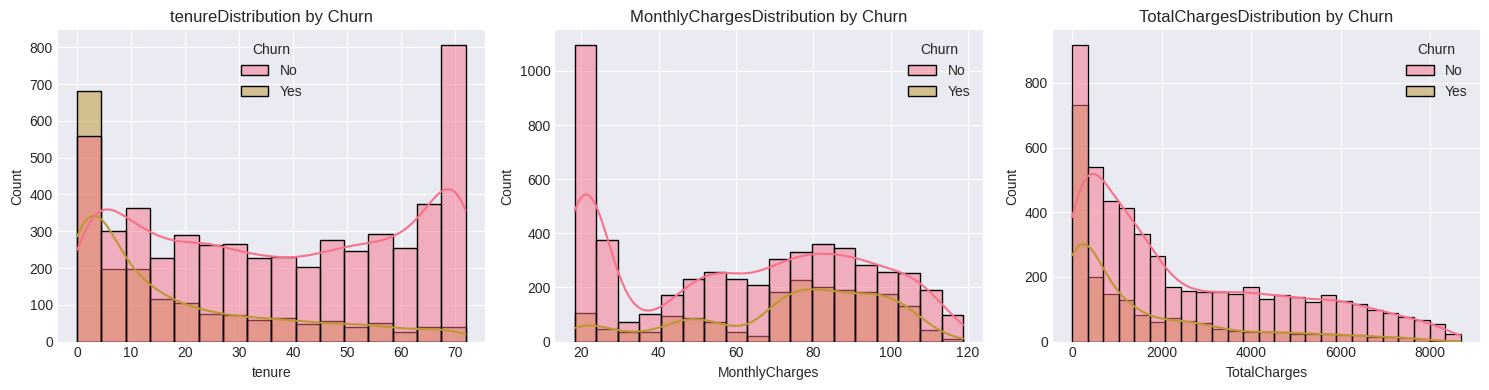

In [96]:
# Numerical Features Analysis

numerical_cols=['tenure', 'MonthlyCharges','TotalCharges']
print(f"Numerical columns:{numerical_cols}")

fig, axes=plt.subplots(1, 3, figsize=(15,4))
for idx, col in enumerate(numerical_cols):
  sns.histplot(data=df, x=col, hue='Churn', kde=True, ax=axes[idx])
  axes[idx].set_title(f'{col}Distribution by Churn')
  axes[idx].set_xlabel(col)
plt.tight_layout()
plt.savefig('numerical_features.png',dpi=300, bbox_inches='tight')
plt.show()



In [97]:
#Statistical summary
print("\n Statistical Summary of Numerical Features:")
print(df[numerical_cols].describe())



 Statistical Summary of Numerical Features:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


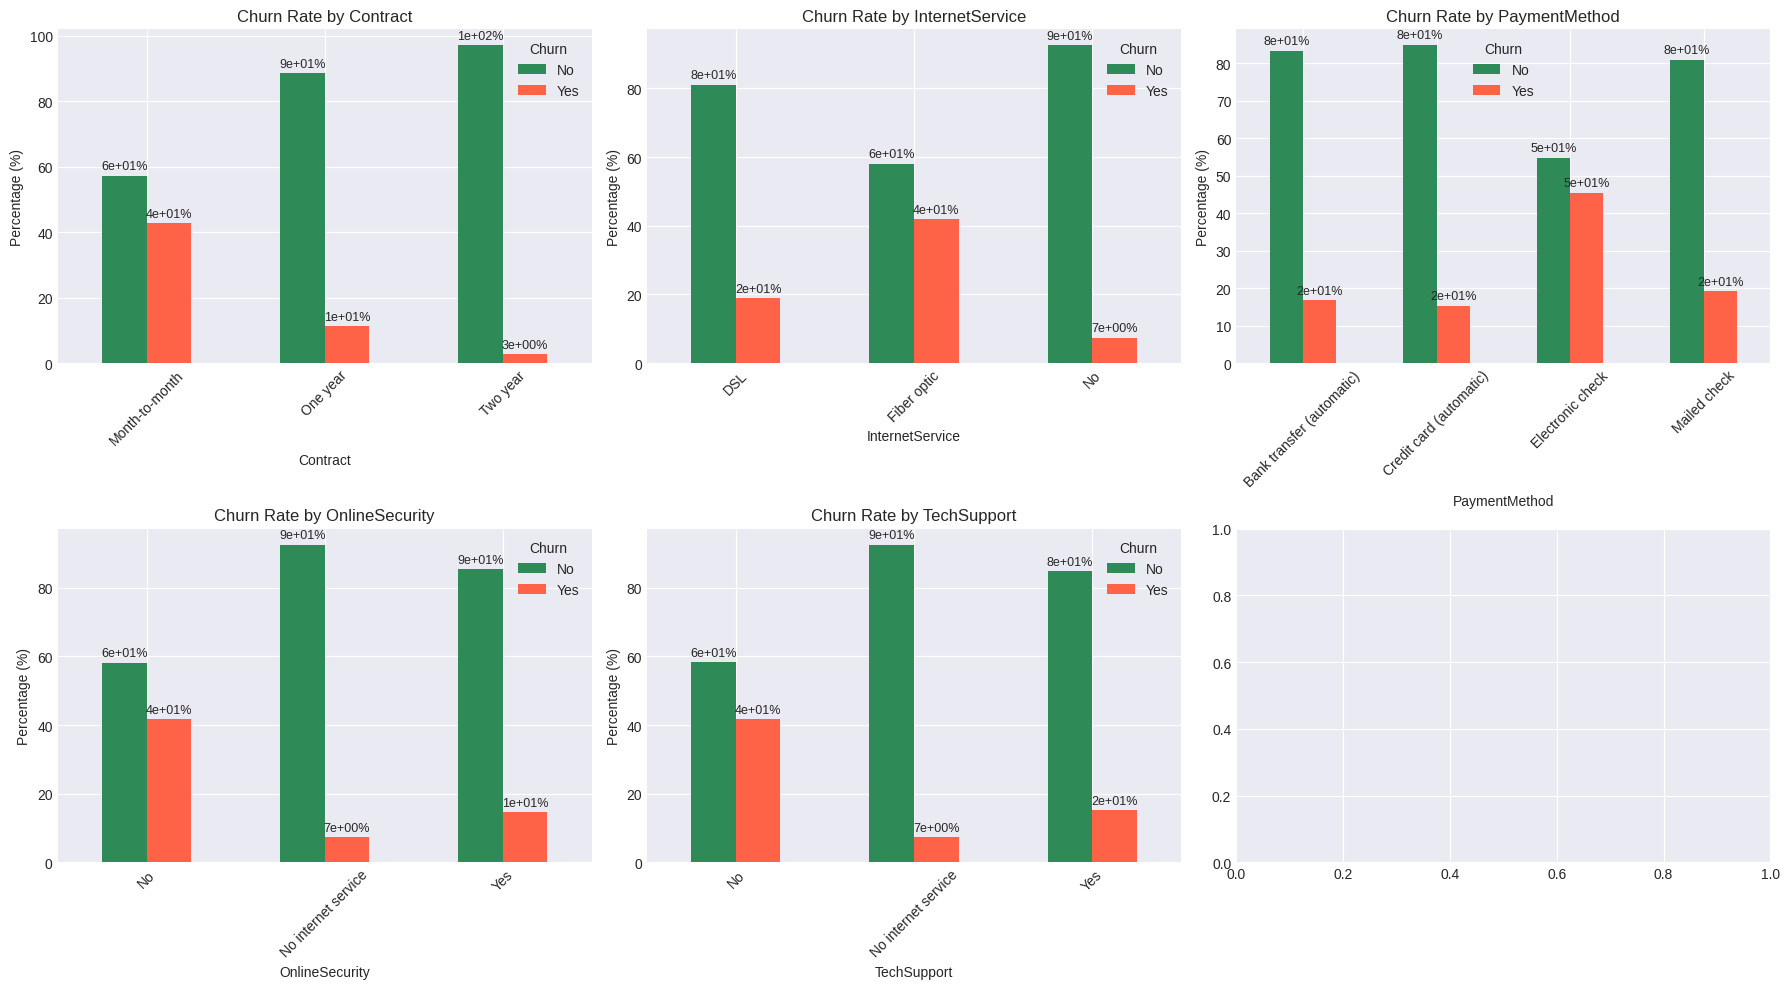


CORRELATION ANALYSIS


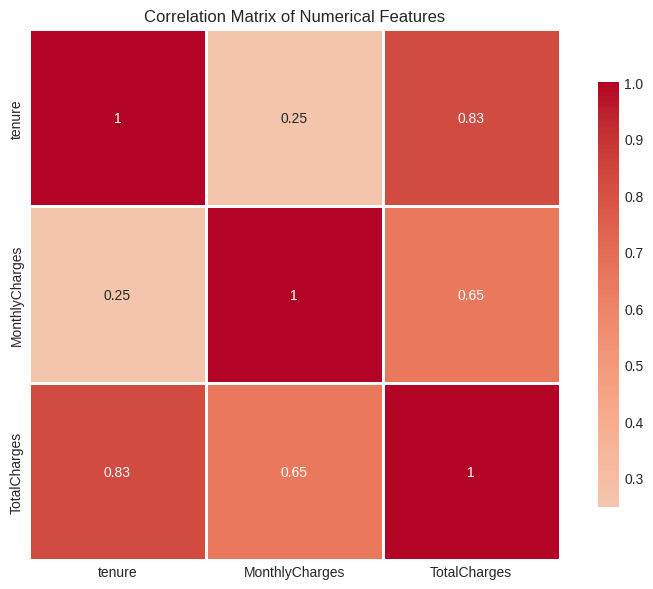


Correlation with Churn (encoded):
Churn_encoded     1.000000
MonthlyCharges    0.193356
TotalCharges     -0.198324
tenure           -0.352229
Name: Churn_encoded, dtype: float64


In [111]:
#Categorical Features Analysis
categorical_cols=['gender','SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

#Converting SeniorCitizen to categorical for better visualization
df['SeniorCitizen']=df['SeniorCitizen'].map({0:'No',1:'Yes'})

#Analyzing top 5 important categorical features
important_cats=['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity', 'TechSupport']

fig, axes=plt.subplots(2, 3, figsize=(18, 10))
axes=axes.flatten()

for idx, col in enumerate(important_cats[:6]):
  #Creating crosstab
  ct=pd.crosstab(df[col], df['Churn'], normalize='index')*100
  ct.plot(kind='bar', ax=axes[idx], color=['#2E8B57', '#FF6347'])
  axes[idx].set_title(f'Churn Rate by {col}')
  axes[idx].set_xlabel(col)
  axes[idx].set_ylabel('Percentage (%)')
  axes[idx].legend(title='Churn')
  axes[idx].tick_params(axis='x', rotation=45)
  #adding percentage labels
  for p in axes[idx].patches:
    height=p.get_height()
    axes[idx].text(p.get_x()+p.get_width()/2., height+1, f'{height:.1}%',ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('categorical_features.png',dpi=300, bbox_inches='tight')
plt.show()

#Correlation Analysis
print("\nCORRELATION ANALYSIS")

#Creating correlation matrix for numerical features
corr_matrix=df[numerical_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink":0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation with Churn (encoded):")
#Encoding churn for correlation
df_corr=df.copy()
df_corr['Churn_encoded']=df_corr['Churn'].map({'No':0,'Yes':1})
correlation_with_churn=df_corr[numerical_cols+['Churn_encoded']].corr()['Churn_encoded'].sort_values(ascending=False)
print(correlation_with_churn)

**Fearture Engineering**

In [100]:
#Creating a Copy of feature engineering
df_encoded=df.copy()

# Convert 'SeniorCitizen' back to integer type (0 or 1) from 'No'/'Yes' strings
# if it was converted in EDA for visualization. This ensures it's treated as a numerical feature
# and will not be passed to the LabelEncoder for categorical columns.
if df_encoded['SeniorCitizen'].dtype == 'object':
    df_encoded['SeniorCitizen'] = df_encoded['SeniorCitizen'].map({'No': 0, 'Yes': 1}).astype(int)

#Encoding categorical variables
print("\nEncoding Categorical Variables")

#List of categorical columns to encode
categorical_cols=df_encoded.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')#We'll handle target separately

# Ensure SeniorCitizen is not in categorical_cols if it was meant to be numerical
# (this check might be redundant if the above conversion works, but adds robustness)
if 'SeniorCitizen' in categorical_cols:
    categorical_cols.remove('SeniorCitizen')

print(f"Categorical columns to encode:{categorical_cols}")

#Applying Label Encoding
label_encoders={}
for col in categorical_cols:
  le=LabelEncoder()
  df_encoded[col]=le.fit_transform(df_encoded[col])
  label_encoders[col]=le
  print(f"Encoded:{col}")

#Encoding target variable
df_encoded['Churn']=df_encoded['Churn'].map({'No':0,'Yes':1})

#Feature Scaling
print("\n FEATURE SCALING")

#Separating features and target
X=df_encoded.drop('Churn', axis=1)
y=df_encoded['Churn']

#Scaling numericall features
scaler=StandardScaler()
numerical_cols_for_scaling=['tenure','MonthlyCharges','TotalCharges']
X[numerical_cols_for_scaling]=scaler.fit_transform(X[numerical_cols_for_scaling])

print(f"Features scaled:{numerical_cols_for_scaling}")
print(f"Final dataset shape:{X.shape}")
print(f"Target variable shape:{y.shape}")


Encoding Categorical Variables
Categorical columns to encode:['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Encoded:gender
Encoded:SeniorCitizen
Encoded:Partner
Encoded:Dependents
Encoded:PhoneService
Encoded:MultipleLines
Encoded:InternetService
Encoded:OnlineSecurity
Encoded:OnlineBackup
Encoded:DeviceProtection
Encoded:TechSupport
Encoded:StreamingTV
Encoded:StreamingMovies
Encoded:Contract
Encoded:PaperlessBilling
Encoded:PaymentMethod

 FEATURE SCALING
Features scaled:['tenure', 'MonthlyCharges', 'TotalCharges']
Final dataset shape:(7043, 19)
Target variable shape:(7043,)


**Data Splitting**

In [101]:
#Splitting data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size:{X_train.shape}")
print(f"Testing set size:{X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")

Training set size:(4930, 19)
Testing set size:(2113, 19)
Training target distribution:
Churn
0    0.734686
1    0.265314
Name: proportion, dtype: float64
Testing target distribution:
Churn
0    0.734501
1    0.265499
Name: proportion, dtype: float64


**Model Building**

In [102]:
print("\nModel Building")
#Dictionary to store model results
model_results={}

#Logistic Regression (Simple & Interpretable)
print("\nMODEL1:LOGISTIC REGRESSION")

lr_model=LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr=lr_model.predict((X_test))
y_pred_proba_lr=lr_model.predict_proba(X_test)[:,1]

#Calculating metrics
accuracy_lr=accuracy_score (y_test, y_pred_lr)
precision_lr=precision_score(y_test, y_pred_lr)
recall_lr=recall_score(y_test, y_pred_lr)
f1_lr=f1_score(y_test, y_pred_lr)
roc_auc_lr=roc_auc_score(y_test, y_pred_proba_lr)

model_results['Logistic Regession']={
    'Accuracy':accuracy_lr,
    'Precision':precision_lr,
    'Recall':recall_lr,
    'F1-Score':f1_lr,
    'ROC-AUC':roc_auc_lr
}

print(f"Accuracy:{accuracy_lr:.4f}")
print(f"Precision:{precision_lr:.4f}")
print(f"Recall:{recall_lr:.4f}")
print(f"F1-Score:{f1_lr:.4f}")
print(f"ROC-AUC:{roc_auc_lr:.4f}")




Model Building

MODEL1:LOGISTIC REGRESSION
Accuracy:0.8003
Precision:0.6427
Recall:0.5579
F1-Score:0.5973
ROC-AUC:0.8418


In [103]:
#Decision Tree
print("\nDecision Tree Classifier")

dt_model=DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)
y_pred_dt=dt_model.predict(X_test)
y_pred_proba_dt=dt_model.predict_proba(X_test)[:,1]

#Calculating metrics
accuracy_dt=accuracy_score(y_test, y_pred_dt)
precision_dt=precision_score(y_test, y_pred_dt)
recall_dt=recall_score(y_test, y_pred_dt)
f1_dt=f1_score(y_test, y_pred_dt)
roc_auc_dt=roc_auc_score(y_test, y_pred_proba_dt)

model_results['Decision Tree']={
    'Accuracy':accuracy_dt,
    'Precision':precision_dt,
    'Recall':recall_dt,
    'F1-Score':f1_dt,
    'ROC-AUC':roc_auc_dt
}

print(f"Accuracy:{accuracy_dt:.4f}")
print(f"Precisin:{precision_dt:.4f}")
print(f"Recall:{recall_dt:.4f}")
print(f"F1-Score:{f1_dt}")
print(f"ROC-AUC:{roc_auc_dt:.4f}")



Decision Tree Classifier
Accuracy:0.7842
Precisin:0.5913
Recall:0.6061
F1-Score:0.5985915492957746
ROC-AUC:0.8256


In [104]:
#K-Nearest Neighbors (Distance-Based)
print("\nMODEL 3:K-NEAREST NEIGHBORS")

knn_model=KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn=knn_model.predict(X_test)
y_pred_proba_knn=knn_model.predict_proba(X_test)[:,1]

#Calculating metrics
accuracy_knn=accuracy_score(y_test, y_pred_knn)
precision_knn=precision_score(y_test, y_pred_knn)
recall_knn=recall_score(y_test,y_pred_knn)
f1_knn=f1_score(y_test, y_pred_knn)
roc_auc_knn=roc_auc_score(y_test, y_pred_proba_knn)

model_results['K-Nearest Neighbors']={
    'Accuracy':accuracy_knn,
    'Precision':precision_knn,
    'Recall':recall_knn,
    'F1-Score':f1_knn,
    'ROC-AUC':roc_auc_knn

}

print(f"Accuracy:{accuracy_knn:.4f}")
print(f"Precision:{precision_knn:.4f}")
print(f"Recall:{recall_knn}")
print(f"F1-Score:{f1_knn:.4f}")
print(f"ROC-AUC{roc_auc_knn:.4f}")



MODEL 3:K-NEAREST NEIGHBORS
Accuracy:0.7549
Precision:0.5390
Recall:0.5294117647058824
F1-Score:0.5342
ROC-AUC0.7673


**Model Evaluation and Comparison**


Model Performance Comparison
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regession   0.800284   0.642710  0.557932  0.597328  0.841786
Decision Tree        0.784193   0.591304  0.606061  0.598592  0.825618
K-Nearest Neighbors  0.754851   0.539020  0.529412  0.534173  0.767275


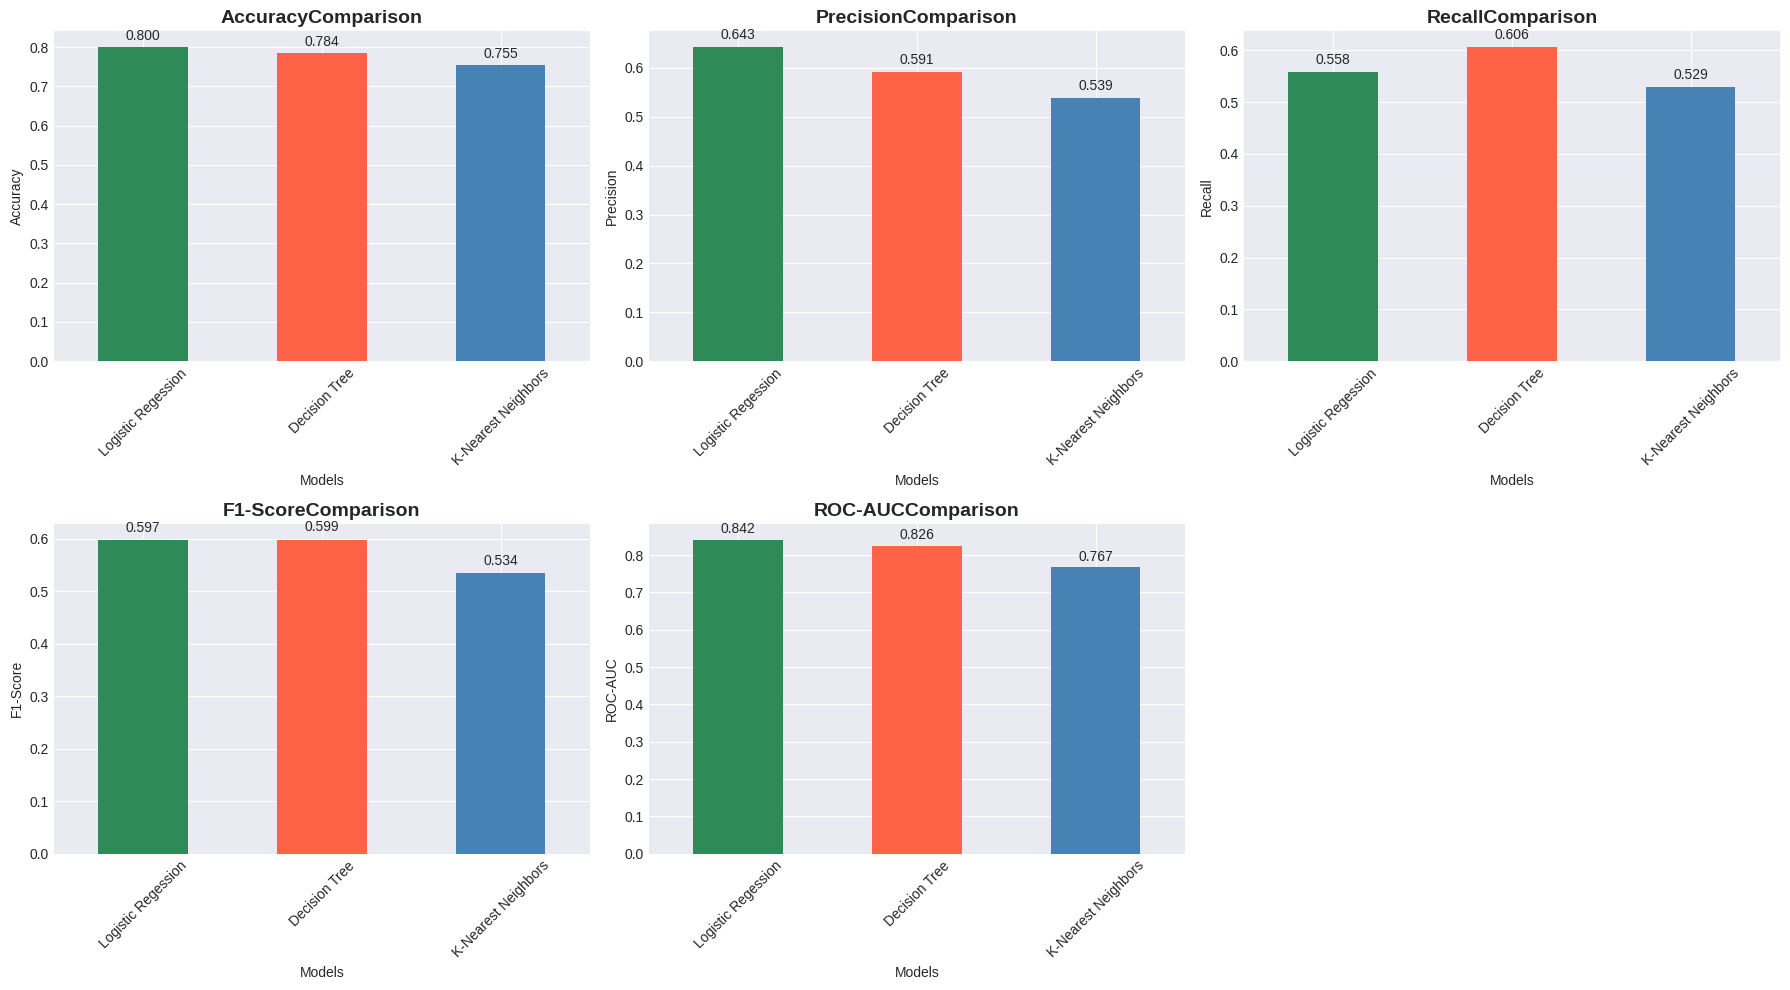


CONFUSION MATRICES


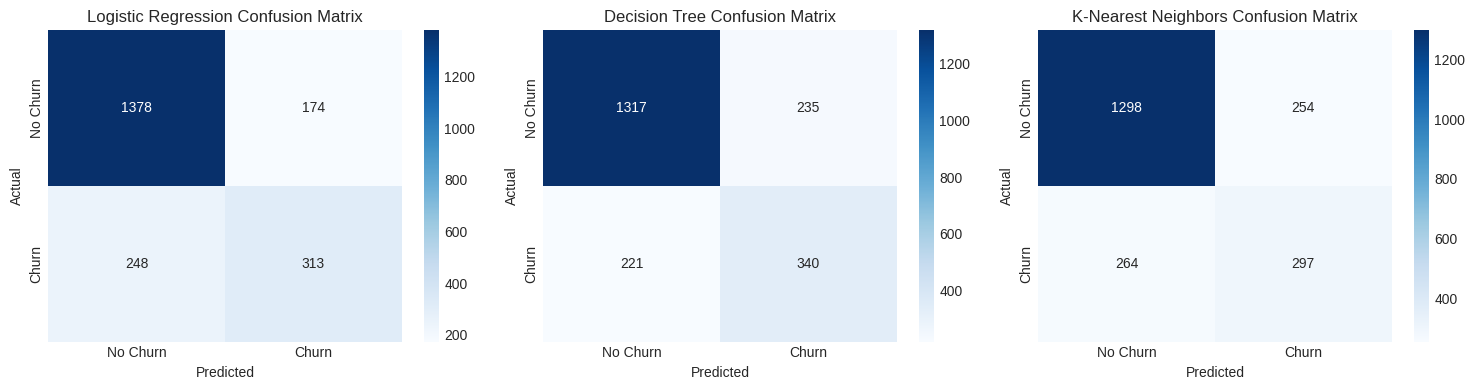


ROC CURVES


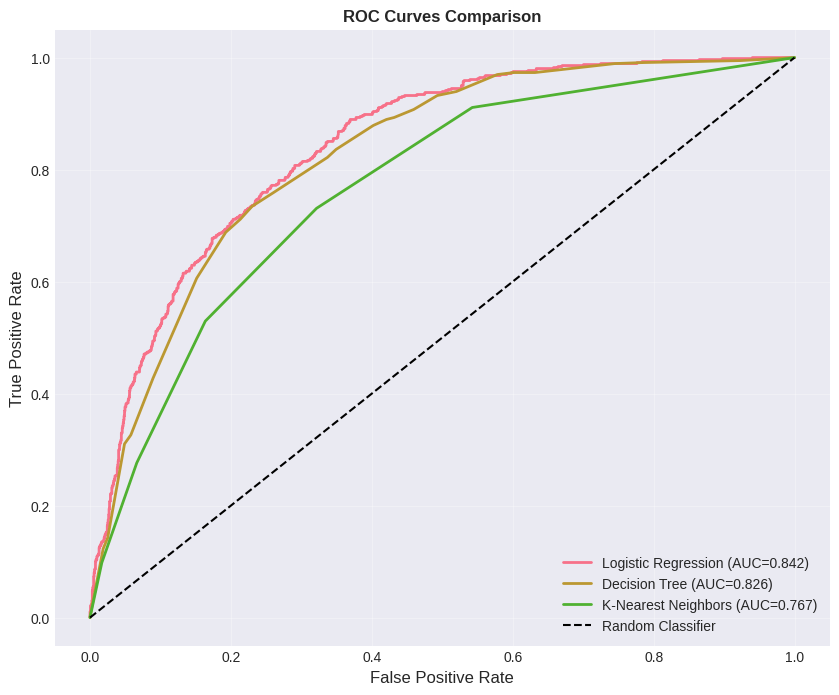


Detailed Classification Reports

LOGISTIC REGRESSION:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1552
       Churn       0.64      0.56      0.60       561

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.80      2113


DECISION TREE:
              precision    recall  f1-score   support

    No Churn       0.86      0.85      0.85      1552
       Churn       0.59      0.61      0.60       561

    accuracy                           0.78      2113
   macro avg       0.72      0.73      0.73      2113
weighted avg       0.79      0.78      0.79      2113


K-NEAREST NEIGHBORS:
              precision    recall  f1-score   support

    No Churn       0.83      0.84      0.83      1552
       Churn       0.54      0.53      0.53       561

    accuracy                           0.75      2113
   macro avg       0.69      0.68  

In [105]:
#Comparing all models
print("\nModel Performance Comparison")

results_df=pd.DataFrame(model_results).T
print(results_df)

#Visuallize model comparison
fig, axes =plt.subplots(2,3,figsize=(18,10))
axes=axes.flatten()

metrics=['Accuracy','Precision','Recall','F1-Score','ROC-AUC']
colors=['#2E8B57', '#FF6347', '#4682B4', '#FFD700']

for idx, metric in enumerate(metrics):
  ax=axes[idx]
  results_df[metric].plot(kind='bar', ax=ax, color=colors[:len(results_df)])
  ax.set_title(f'{metric}Comparison', fontsize=14, fontweight='bold')
  ax.set_xlabel('Models')
  ax.set_ylabel(metric)
  ax.tick_params(axis='x',rotation=45)

  #Adding value labels on bars
  for i, v in enumerate(results_df[metric]):
    ax.text(i, v+0.01,f'{v:.3f}',ha='center',va='bottom',fontsize=10)

#Ploting confusion matrices for each model
axes[5].axis('off')#Hiding the last subplot

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#Confusion Matrices
print("\nCONFUSION MATRICES")

fig, axes=plt.subplots(1, 3, figsize=(15,4))
models=[('Logistic Regression', y_pred_lr),
       ('Decision Tree', y_pred_dt),
       ('K-Nearest Neighbors',y_pred_knn)]

for idx, (name, y_pred)in enumerate(models):
  cm=confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
  axes[idx].set_title(f'{name} Confusion Matrix')
  axes[idx].set_xlabel('Predicted')
  axes[idx].set_ylabel('Actual')
  axes[idx].set_xticklabels(['No Churn', 'Churn'])
  axes[idx].set_yticklabels(['No Churn','Churn'])

plt.tight_layout()
plt.savefig('confusion_matrices.png',dpi=300, bbox_inches='tight')
plt.show()

#ROC Curves
print("\nROC CURVES")
plt.figure(figsize=(10,8))

#Plot ROC for each model
y_pred_probas={
    'Logistic Regression':y_pred_proba_lr,
    'Decision Tree':y_pred_proba_dt,
    'K-Nearest Neighbors':y_pred_proba_knn
}

for model_name, y_pred_proba in y_pred_probas.items():
  fpr, tpr, _ =roc_curve(y_test, y_pred_proba)
  auc_score=roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})',linewidth=2)

plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

#Classification Reports
print("\nDetailed Classification Reports")

print("\nLOGISTIC REGRESSION:")
print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))

print("\nDECISION TREE:")
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))

print("\nK-NEAREST NEIGHBORS:")
print(classification_report(y_test, y_pred_knn, target_names=['No Churn', 'Churn']))

**Feature Importance Analysis**


Top 10 Most Important Features:
             Feature  Importance
14          Contract    0.515611
8     OnlineSecurity    0.138426
4             tenure    0.116408
7    InternetService    0.084084
17    MonthlyCharges    0.067822
18      TotalCharges    0.039316
16     PaymentMethod    0.015529
6      MultipleLines    0.010315
15  PaperlessBilling    0.009817
3         Dependents    0.002674


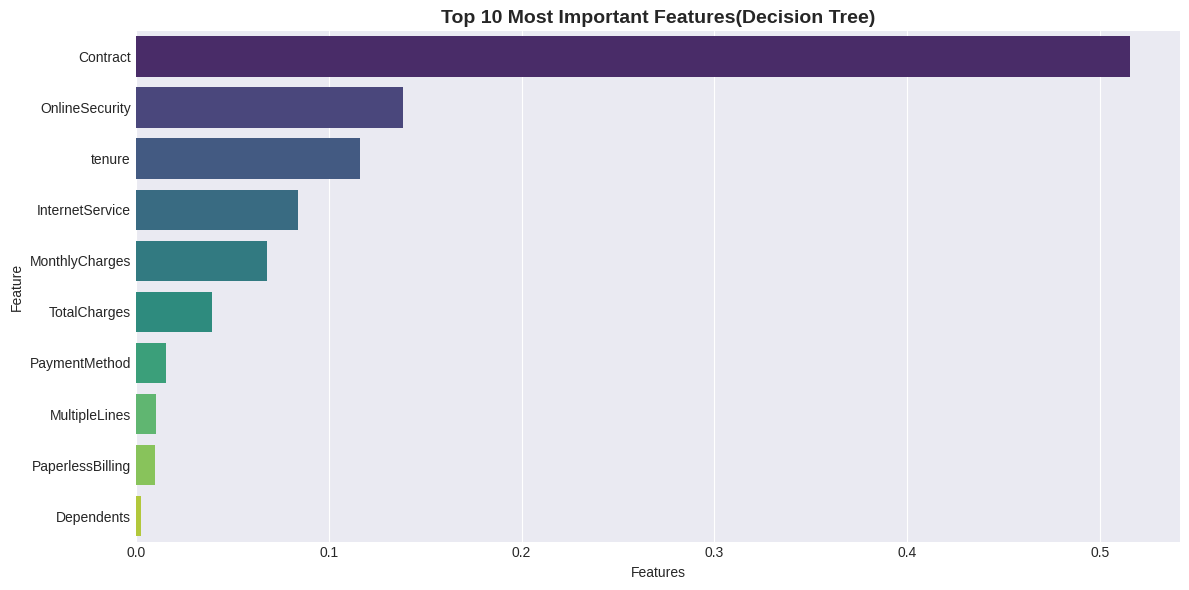

In [106]:
#Feature importance from Decision Tree
feature_importance=pd.DataFrame({
    'Feature':X.columns,
    'Importance':dt_model.feature_importances_
})
feature_importance=feature_importance.sort_values('Importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

#Visualizing feature importance
plt.figure(figsize=(12,6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Most Important Features(Decision Tree)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png',dpi=300, bbox_inches='tight')
plt.show()


In [107]:
#Business insights from importance
print("\nBUSINESS INSIGHTS FROM FEATURE IMPORTANCE:")
top_features =feature_importance.head(5)
for idx, row in top_features.iterrows():
  print(f"{row['Feature']}:Importance={row['Importance']:.3f}")

  #Adding business interpretation
  if row['Feature']=='Contract':
    print("Contract type is crucial- Longer contracts reduce churn")
  elif row['Feature']=='tenure':
    print("Tenure matters-Longer tenure customers are more loyal")
  elif row ['Feature']=='MonthlyCharges':
    print("Monthly charges affect churn- Higher charges may cause dissatisfaction")
  elif row['Feature']=='InternetService':
    print("Internet service type impacts retention")
  elif 'online' in row['Feature']:
    print(f"{row['Feature']}service influences customer satisfaction")
  print()



BUSINESS INSIGHTS FROM FEATURE IMPORTANCE:
Contract:Importance=0.516
Contract type is crucial- Longer contracts reduce churn

OnlineSecurity:Importance=0.138

tenure:Importance=0.116
Tenure matters-Longer tenure customers are more loyal

InternetService:Importance=0.084
Internet service type impacts retention

MonthlyCharges:Importance=0.068
Monthly charges affect churn- Higher charges may cause dissatisfaction



**Final Model Selection & Deployment**

In [108]:
import joblib

In [109]:
print("\n\nFINAL MODEL SELECTION")
#Selecting the best model based on F1-Score(balances precision and recall)
best_model_name=max(model_results, key=lambda x: model_results[x]['F1-Score'])
best_model_score=model_results[best_model_name]['F1-Score']

print(f"Selected Best Model:{best_model_name}")
print(f"Best F1-Score:{best_model_score:.4f}")
print(f"Accuracy:{model_results[best_model_name]['Accuracy']:.4f}")
print(f"Precision:{model_results[best_model_name]['Precision']:.4f}")
print(f"Recall:{model_results[best_model_name]['Recall']}")

#Retraining the best model on full training data
print("\nRetraining best model on full training data...")
if best_model_name=="Logistic Regression":
  final_model=LogisticRegression(random_state=42, max_iter=1000)
elif best_model_name=="Decision Tree":
  final_model=DecisionTreeClassifier(random_state=42, max_depth=5)
else:
  final_model=KNeighborsClassifier(n_neighbors=5)

final_model.fit(X_train, y_train)

#Testing final model on test set
y_pred_final=final_model.predict(X_test)
final_accuracy=accuracy_score(y_test, y_pred_final)
print(f"Final Model test accuracy:{final_accuracy:.4f}")

#Saving the final model and preprocessing objects

model_data={
    'model':final_model,
    'scaler':scaler,
    'label_encoders':label_encoders,
    'feature_names':X.columns.tolist()
 }

joblib.dump(model_data,'churn_prediction_model.pkl')
print("Model saved as 'churn_prediction_model.pkl'")





FINAL MODEL SELECTION
Selected Best Model:Decision Tree
Best F1-Score:0.5986
Accuracy:0.7842
Precision:0.5913
Recall:0.6060606060606061

Retraining best model on full training data...
Final Model test accuracy:0.7842
Model saved as 'churn_prediction_model.pkl'


**Prediction on new Data(Demonstrtion)**

In [119]:
print("PREDICTION FOR NEW CUSTOMER")
# Creating customer
new_customer = {
    'gender': 'Male',
    'SeniorCitizen': 0,  # This is 0 or 1, NOT 'No' or 'Yes'
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 89.5,
    'TotalCharges': 1074.0
}

print("\nCustomer Profile:")
for k, v in new_customer.items():
    print(f"{k:20s}: {v}")

# Loading the saved model and preprocessing objects
import joblib
loaded_model_data = joblib.load('churn_prediction_model.pkl')
final_model = loaded_model_data['model']
scaler = loaded_model_data['scaler']
label_encoders = loaded_model_data['label_encoders']
feature_names = loaded_model_data['feature_names'] # Get feature names to ensure consistent order

print("\nPreprocessing...")

# Convert new_customer_data to DataFrame
df_customer = pd.DataFrame([new_customer])

# Applying label encoding using the stored encoders for categorical columns
for col, le in label_encoders.items():
    if col in df_customer.columns:
        # Skip 'SeniorCitizen' as it's handled as a numerical feature
        if col == 'SeniorCitizen':
            print(f"Skipped encoding for {col} (numerical)")
            continue
        try:
            df_customer[col] = le.transform(df_customer[col])
            print(f"Encoded {col}")
        except ValueError as e:
            # Handle unseen labels by mapping to default (e.g., first class) or raising an error
            print(f"Error encoding '{col}': {e}. Using first known class.")
            df_customer[col] = le.transform([le.classes_[0]])

# Scale numerical columns using the loaded scaler
numerical_cols_for_scaling=['tenure','MonthlyCharges','TotalCharges'] # This was defined earlier
# Adding 'SeniorCitizen' to scaling if desired, otherwise it will remain as 0/1
# For this dataset, 'SeniorCitizen' is typically not scaled with StandardScaler if kept as 0/1 indicator.
# If it were to be scaled, it would be added to numerical_cols_for_scaling during training.
# Assuming it's not scaled here as per typical practice for binary indicator features.
if all(col in df_customer.columns for col in numerical_cols_for_scaling):
    df_customer[numerical_cols_for_scaling] = scaler.transform(df_customer[numerical_cols_for_scaling])
    print(f"Scaled numerical features: {numerical_cols_for_scaling}")
else:
    print(f"Not all numerical columns found for scaling: {numerical_cols_for_scaling}")

# Ensuring the order of columns matches the training data (X)
df_customer_final = df_customer[feature_names]

# Using the loaded final model for prediction
model_name = final_model.__class__.__name__
print(f"\n Using model: {model_name}")

# Predicting
pred = final_model.predict(df_customer_final)[0]
proba = final_model.predict_proba(df_customer_final)[0]

print("\nPREDICTION RESULTS")

print(f"\nFinal Prediction: {'WILL CHURN ' if pred == 1 else 'WILL STAY '}")
print(f"\nProbability of churning: {proba[1]*100:.1f}%")
print(f"\nProbability of staying:  {proba[0]*100:.1f}%")

# Confidence
confidence = abs(proba[1] - proba[0]) * 100
if confidence > 30:
    print(f"High confidence: {confidence:.1f}%")
elif confidence > 15:
    print(f"Medium confidence: {confidence:.1f}%")
else:
    print(f"Low confidence: {confidence:.1f}%")


#Risk analysis
print("RISK ANALYSIS")
print("\nThis customer scores HIGH on these risk factors:")

risk_score = 0
high_risk = []
medium_risk = []

# HIGH RISK FACTORS (2 points each)
if new_customer['Contract'] == 'Month-to-month':
    high_risk.append("Month-to-month contract")
    risk_score += 2

if new_customer['PaymentMethod'] == 'Electronic check':
    high_risk.append("Pays by electronic check")
    risk_score += 2

# MEDIUM RISK FACTORS (1 point each)
if new_customer['tenure'] < 12:
    medium_risk.append(f"New customer ({new_customer['tenure']} months)")
    risk_score += 1

if new_customer['MonthlyCharges'] > 70:
    medium_risk.append(f"High bill (${new_customer['MonthlyCharges']}/month)")
    risk_score += 1

# Checking for missing services
important_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
missing = [s for s in important_services if new_customer[s] == 'No']
if len(missing) >= 3:
    medium_risk.append(f"Missing {len(missing)} security services")
    risk_score += 1

# Displaying risks
if high_risk:
    print("\nHIGH RISK:")
    for risk in high_risk:
        print(f"  • {risk}")

if medium_risk:
    print("\nMEDIUM RISK:")
    for risk in medium_risk:
        print(f"  • {risk}")

print(f"\nTotal Risk Score: {risk_score}/7")
if risk_score >= 4:
    print("OVERALL: HIGH RISK CUSTOMER")
elif risk_score >= 2:
    print("OVERALL: MEDIUM RISK CUSTOMER")
else:
    print("OVERALL: LOW RISK CUSTOMER")


#Action Plan
print("RECOMMENDED ACTION PLAN")
if pred == 1 or proba[1] > 0.5:
    print("\nURGENT: This customer is at high risk of leaving!")

    print("\nIMMEDIATE ACTIONS:")
    print("1. Call within 24 hours to check satisfaction")
    print("2. Offer personalized retention deal")

    print("\nRECOMMENDED OFFERS:")
    if new_customer['Contract'] == 'Month-to-month':
        print("   • 12-month contract: 15% discount")
        print("   • Free upgrade to next service tier")

    if new_customer['PaymentMethod'] == 'Electronic check':
        print("   • Switch to auto-pay: $10 monthly credit")

    if new_customer['MonthlyCharges'] > 70:
        print("   • Free service review to optimize costs")

    print("\nRetention script:")
    print('   "Hi, we noticed you\'ve been with us for a while.')
    print('    We value your business and would like to offer')
    print('    a special loyalty discount just for you!"')

else:
    print("\nSTABLE: This customer is likely to stay")

    print("\nRECOMMENDED ACTIONS:")
    print("1. Send thank you email")
    print("2. Consider loyalty rewards")
    print("3. Regular check-in every 3 months")

    if risk_score > 0:
        print("\nConsider offering:")
        print("   • Small discount on add-on services")
        print("   • Referral bonus program")


print("PREDICTION COMPLETE")


# Save the prediction
import datetime
result = {
    'date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),
    'customer': 'New_Customer_001',
    'prediction': 'Churn' if pred == 1 else 'No Churn',
    'churn_probability': f"{proba[1]*100:.1f}%",
    'risk_score': risk_score,
    'key_risks': ', '.join(high_risk + medium_risk)
}

print("\nPrediction Summary:")
for key, value in result.items():
    print(f"{key:20s}: {value}")

PREDICTION FOR NEW CUSTOMER

Customer Profile:
gender              : Male
SeniorCitizen       : 0
Partner             : No
Dependents          : No
tenure              : 12
PhoneService        : Yes
MultipleLines       : No
InternetService     : Fiber optic
OnlineSecurity      : No
OnlineBackup        : No
DeviceProtection    : No
TechSupport         : No
StreamingTV         : No
StreamingMovies     : No
Contract            : Month-to-month
PaperlessBilling    : Yes
PaymentMethod       : Electronic check
MonthlyCharges      : 89.5
TotalCharges        : 1074.0

Preprocessing...
Encoded gender
Skipped encoding for SeniorCitizen (numerical)
Encoded Partner
Encoded Dependents
Encoded PhoneService
Encoded MultipleLines
Encoded InternetService
Encoded OnlineSecurity
Encoded OnlineBackup
Encoded DeviceProtection
Encoded TechSupport
Encoded StreamingTV
Encoded StreamingMovies
Encoded Contract
Encoded PaperlessBilling
Encoded PaymentMethod
Scaled numerical features: ['tenure', 'MonthlyCharges',